In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
import seaborn as sns
import faiss
import os

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')
run_stats = {}

In [2]:
# parameters
dataset_name = ""
model_name = "resnet_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "CIFAR10"
ood = ""


In [4]:
# initialize data attributes and loaders
save_name = f"assets/results/{dataset_name}/{model_name}/{ood}"
os.makedirs(os.path.dirname(save_name + "_blank.file"), exist_ok=True)
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data(shuffle_training_data=False)
config.print_labels()
dm = config.datamodule

assert dm

Files already downloaded and verified


  0%|                                                                                                                   | 0/50000 [00:00<?, ?it/s]

 10%|█████████▋                                                                                           | 4793/50000 [00:00<00:00, 47922.73it/s]

 19%|███████████████████▍                                                                                 | 9629/50000 [00:00<00:00, 48177.39it/s]

 29%|████████████████████████████▉                                                                       | 14455/50000 [00:00<00:00, 48212.98it/s]

 39%|██████████████████████████████████████▌                                                             | 19281/50000 [00:00<00:00, 48229.88it/s]

 48%|████████████████████████████████████████████████▏                                                   | 24123/50000 [00:00<00:00, 48297.16it/s]

 58%|█████████████████████████████████████████████████████████▉                                          | 28968/50000 [00:00<00:00, 48345.89it/s]

 68%|███████████████████████████████████████████████████████████████████▌                                | 33803/50000 [00:00<00:00, 48332.33it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▎                      | 38642/50000 [00:00<00:00, 48347.80it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████▉             | 43477/50000 [00:00<00:00, 48328.91it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████▋   | 48322/50000 [00:01<00:00, 48363.27it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:01<00:00, 48296.58it/s]

Files already downloaded and verified


  0%|                                                                                                                   | 0/10000 [00:00<?, ?it/s]

 48%|████████████████████████████████████████████████                                                     | 4754/10000 [00:00<00:00, 47530.87it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▌    | 9564/10000 [00:00<00:00, 47860.28it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 47726.49it/s]

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

 2oy5iigc


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-2oy5iigc:best, 58.52MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:3.5


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_rcn = []
    trn_emb = []
    trn_tgt = []

    val_inp = []
    val_rcn = []
    val_emb = []
    val_tgt = []

    ind_inp = []
    ind_rcn = []
    ind_emb = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_rcn = []
        ood_emb = []
        ood_tgt = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            emb, lgt, rcn = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

  0%|                                                                                                                     | 0/313 [00:00<?, ?it/s]

  0%|▎                                                                                                            | 1/313 [00:00<02:59,  1.74it/s]

  4%|████▊                                                                                                       | 14/313 [00:00<00:11, 27.10it/s]

  9%|█████████▎                                                                                                  | 27/313 [00:00<00:05, 49.61it/s]

 13%|█████████████▊                                                                                              | 40/313 [00:00<00:03, 68.59it/s]

 17%|██████████████████▎                                                                                         | 53/313 [00:00<00:03, 83.84it/s]

 21%|██████████████████████▊                                                                                     | 66/313 [00:01<00:02, 95.61it/s]

 25%|███████████████████████████                                                                                | 79/313 [00:01<00:02, 104.66it/s]

 29%|███████████████████████████████▍                                                                           | 92/313 [00:01<00:01, 111.28it/s]

 34%|███████████████████████████████████▌                                                                      | 105/313 [00:01<00:01, 116.11it/s]

 38%|███████████████████████████████████████▉                                                                  | 118/313 [00:01<00:01, 119.60it/s]

 42%|████████████████████████████████████████████▎                                                             | 131/313 [00:01<00:01, 121.31it/s]

 46%|████████████████████████████████████████████████▊                                                         | 144/313 [00:01<00:01, 123.32it/s]

 50%|█████████████████████████████████████████████████████▏                                                    | 157/313 [00:01<00:01, 124.74it/s]

 54%|█████████████████████████████████████████████████████████▌                                                | 170/313 [00:01<00:01, 125.80it/s]

 58%|█████████████████████████████████████████████████████████████▉                                            | 183/313 [00:02<00:01, 126.31it/s]

 63%|██████████████████████████████████████████████████████████████████▍                                       | 196/313 [00:02<00:00, 126.66it/s]

 67%|██████████████████████████████████████████████████████████████████████▊                                   | 209/313 [00:02<00:00, 127.10it/s]

 71%|███████████████████████████████████████████████████████████████████████████▏                              | 222/313 [00:02<00:00, 127.34it/s]

 75%|███████████████████████████████████████████████████████████████████████████████▌                          | 235/313 [00:02<00:00, 127.68it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████▉                      | 248/313 [00:02<00:00, 127.87it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████▍                 | 261/313 [00:02<00:00, 127.81it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████▊             | 274/313 [00:02<00:00, 127.94it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████▏        | 287/313 [00:02<00:00, 127.96it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 300/313 [00:02<00:00, 127.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 114.23it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 101.81it/s]

train - OK


  0%|                                                                                                                      | 0/79 [00:00<?, ?it/s]

  3%|██▊                                                                                                           | 2/79 [00:00<00:04, 18.98it/s]

 19%|████████████████████▋                                                                                        | 15/79 [00:00<00:00, 81.74it/s]

 35%|██████████████████████████████████████▎                                                                     | 28/79 [00:00<00:00, 102.55it/s]

 52%|████████████████████████████████████████████████████████                                                    | 41/79 [00:00<00:00, 112.51it/s]

 68%|█████████████████████████████████████████████████████████████████████████▊                                  | 54/79 [00:00<00:00, 118.17it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▌                | 67/79 [00:00<00:00, 121.42it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 100.09it/s]

val - OK


  0%|                                                                                                                      | 0/79 [00:00<?, ?it/s]

  1%|█▍                                                                                                            | 1/79 [00:00<00:07,  9.98it/s]

 18%|███████████████████▎                                                                                         | 14/79 [00:00<00:00, 79.10it/s]

 34%|████████████████████████████████████▉                                                                       | 27/79 [00:00<00:00, 100.89it/s]

 51%|██████████████████████████████████████████████████████▋                                                     | 40/79 [00:00<00:00, 110.96it/s]

 67%|████████████████████████████████████████████████████████████████████████▍                                   | 53/79 [00:00<00:00, 116.64it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▏                 | 66/79 [00:00<00:00, 120.04it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 105.39it/s]

test InD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_rcn = np.array(trn_rcn)
trn_emb = np.array(trn_emb).squeeze()
trn_tgt = np.array(trn_tgt)
np.savez_compressed(f"{save_name}_trn.npz", inp=trn_inp, rcn=trn_rcn, emb=trn_emb, tgt=trn_tgt)

val_inp = np.array(val_inp)
val_rcn = np.array(val_rcn)
val_emb = np.array(val_emb).squeeze()
val_tgt = np.array(val_tgt)
np.savez_compressed(f"{save_name}_val.npz", inp=val_inp, rcn=val_rcn, emb=val_emb, tgt=val_tgt)

ind_inp = np.array(ind_inp)
ind_rcn = np.array(ind_rcn)
ind_emb = np.array(ind_emb).squeeze()
ind_tgt = np.array(ind_tgt)
np.savez_compressed(f"{save_name}_ind.npz", inp=ind_inp, rcn=ind_rcn, emb=ind_emb, tgt=ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_rcn = np.array(ood_rcn)
    ood_emb = np.array(ood_emb).squeeze()
    ood_tgt = np.array(ood_tgt)
    np.savez_compressed(f"{save_name}_ood.npz", inp=ood_inp, rcn=ood_rcn, emb=ood_emb, tgt=ood_tgt)

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_rcn.shape, trn_emb.shape, trn_tgt.shape)
print(val_inp.shape, val_rcn.shape, val_emb.shape, val_tgt.shape)
print(ind_inp.shape, ind_rcn.shape, ind_emb.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_rcn.shape, ood_emb.shape, ood_tgt.shape)

(40000, 3, 32, 32) (40000, 3, 32, 32) (40000, 512) (40000,)
(10000, 3, 32, 32) (10000, 3, 32, 32) (10000, 512) (10000,)
(10000, 3, 32, 32) (10000, 3, 32, 32) (10000, 512) (10000,)


In [11]:
# create 2d embeddings
n = ind_emb.shape[0]
all_emb = ind_emb
if ood_str:
    all_emb = np.concatenate([all_emb, ood_emb], axis=0)

umap = UMAP(n_components=2, random_state=42)
all_emb2d = umap.fit_transform(all_emb)
ind_emb2d = np.array(all_emb2d[:n], order='C').astype(np.float32)
ood_emb2d = np.array(all_emb2d[n:], order='C').astype(np.float32)
print(ind_emb2d.shape, ood_emb2d.shape)

/n/home12/yasith/.conda/envs/robustml/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(10000, 2) (0, 2)


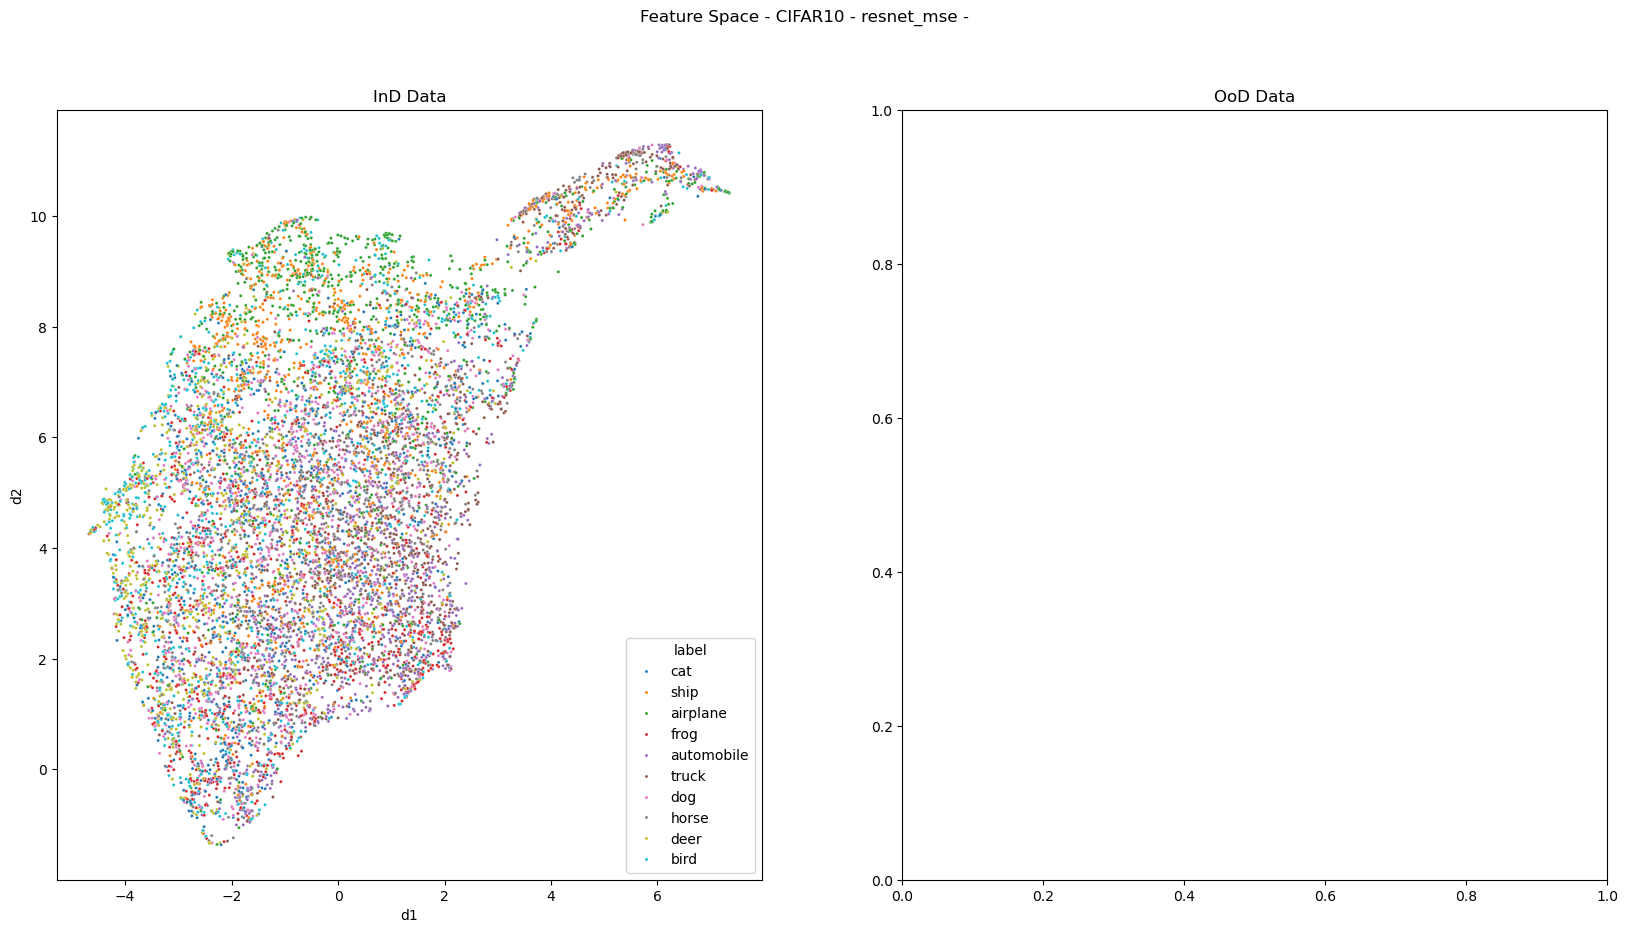

In [12]:
# plot feature space
df_emb2d = pd.DataFrame()
d1, d2 = ind_emb2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_emb2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

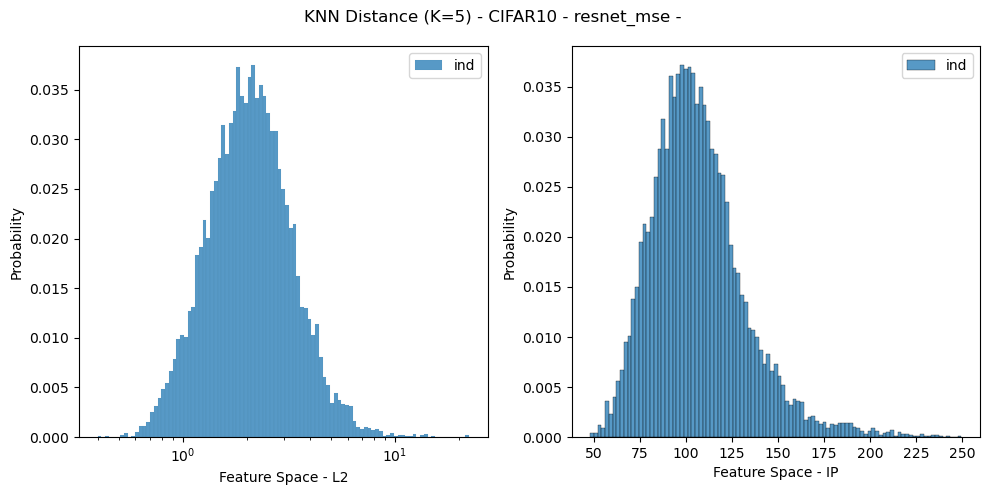

In [13]:
# plot knn distance from ind/ood to val data
def plot_knn_dists(index_fn, ax, trn_data, val_data, ind_data, ood_data=None, k=5, scale="linspace"):
    stats = {}
    index = index_fn(trn_data.shape[-1])
    index.add(trn_data)
    Dv = index.search(val_data, k)[0].mean(-1)
    Di = index.search(ind_data, k)[0].mean(-1)
    D = [Di]
    T = [[0] * Di.shape[0]]
    if ood_str:
        Do = index.search(ood_data, k)[0].mean(-1)
        D.append(Do)
        T.append([1] * Do.shape[0]) 
    D = np.concatenate(D, axis=0)
    T = np.concatenate(T, axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    prefix = ""
    if ood_str:
        Ci = np.histogram(Di, bins, density=True)[0]
        Co = np.histogram(Do, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(Do, Di)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
        ax.set_title(f"KL={kld:.4f} EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc, val_data=Dv.tolist(), ind_data=Di.tolist(), ood_data=Do.tolist()))
        
    if scale == "logspace":
        ax.set_xscale('log')
    ax.legend()
    return stats

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
fig.suptitle(f"KNN Distance (K=5) - {dataset_name} - {model_name} - {ood_str}")
run_stats["knn_f_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[0], trn_emb, val_emb, ind_emb, ood_emb if ood_str else None, scale="logspace")
axs[0].set_xlabel("Feature Space - L2")
run_stats["knn_f_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[1], trn_emb, val_emb, ind_emb, ood_emb if ood_str else None, scale="linspace")
axs[1].set_xlabel("Feature Space - IP")
plt.tight_layout()
plt.show()

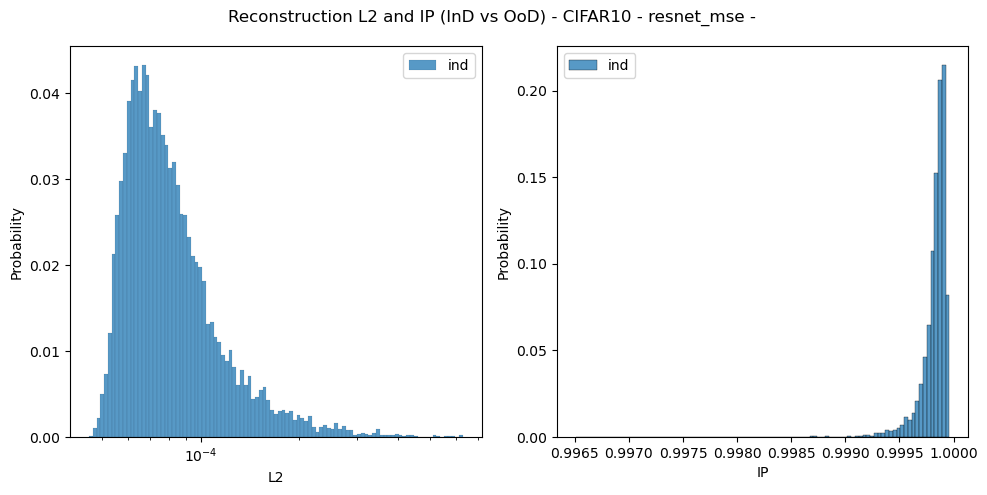

In [14]:
# plot reconstruction error of ind and ood data
def plot_rcn(val_rcn, ind_rcn, ood_rcn, ax, scale="linspace"):
    stats = {}
    D = ind_rcn
    if ood_str:
        D = np.concatenate([ind_rcn, ood_rcn], axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(ind_rcn, label="ind", stat="probability", bins=bins, ax=ax)
    if ood_str:
        sns.histplot(ood_rcn, label="ood", stat="probability", bins=bins, ax=ax)
        T = np.concatenate([[0]*ind_rcn.shape[0],[1]*ood_rcn.shape[0]], axis=0)
        Ci = np.histogram(ind_rcn, bins, density=True)[0]
        Co = np.histogram(ood_rcn, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(ood_rcn, ind_rcn)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        ax.set_title(f"KL={kld:.4f}, EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc, val_data=val_rcn.tolist(), ind_data=ind_rcn.tolist(), ood_data=ood_rcn.tolist()))
    if scale == "logspace":
        ax.set_xscale("log")
    ax.legend()
    return stats

flatten = lambda x: x.reshape((x.shape[0], -1))
unit = lambda x: x / (np.linalg.norm(x, axis=-1, keepdims=True) + 1e-7)

# training data
_val_inp, _val_rcn = flatten(val_inp), flatten(val_rcn)
_val_inp_unit, _val_rcn_unit = unit(_val_inp), unit(_val_rcn)
# metrics
val_rcn_l2 = ((_val_inp - _val_rcn) ** 2).mean(-1)
val_rcn_ip = (_val_inp_unit * _val_rcn_unit).sum(-1)

# ind test data
_ind_inp, _ind_rcn = flatten(ind_inp), flatten(ind_rcn)
_ind_inp_unit, _ind_rcn_unit = unit(_ind_inp), unit(_ind_rcn)
# metrics
ind_rcn_l2 = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_rcn_ip = (_ind_inp_unit * _ind_rcn_unit).sum(-1)

if ood_str:
    # ood test data
    _ood_inp, _ood_rcn = flatten(ood_inp), flatten(ood_rcn)
    _ood_inp_unit, _ood_rcn_unit = unit(_ood_inp), unit(_ood_rcn)
    # metrics
    ood_rcn_l2 = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_rcn_ip = (_ood_inp_unit * _ood_rcn_unit).sum(-1)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
run_stats["rcn_l2"] = plot_rcn(val_rcn_l2, ind_rcn_l2, ood_rcn_l2 if ood_str else None, ax1, scale="logspace")
ax1.set_xlabel("L2")
run_stats["rcn_ip"] = plot_rcn(val_rcn_ip, ind_rcn_ip, ood_rcn_ip if ood_str else None, ax2, scale="linspace")
ax2.set_xlabel("IP")
plt.suptitle(f"Reconstruction L2 and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

In [15]:
run_stats.update(dict(dataset_name=dataset_name, model_name=model_name, ood=ood))
import gzip
import pickle
with gzip.open(f"{save_name}_stats.gz", "wb") as f:
    pickle.dump(run_stats, f)